## Univariate Model: ARIMA

In this section, we conduct a detailed univariate ARIMA analysis on the log return series of Bitcoin and Ethereum. Our aim is to determine whether the return series exhibit any time-dependent structure that could be useful for forecasting. We begin by testing for stationarity, then examine the autocorrelation structure, and finally perform model selection based on both the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC).

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import os

In [3]:
# Load in datasets
df_btc = pd.read_csv('../data/btc_data.csv')
df_eth = pd.read_csv('../data/eth_data.csv')
df_sp500 = pd.read_csv('../data/sp500_data.csv')
df_vix = pd.read_csv('../data/vix_data.csv')
df_gold = pd.read_csv('../data/gold_data.csv')

In [4]:
for df in [df_btc, df_eth, df_sp500, df_vix, df_gold]:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

## Stationarity Testing

We have used the Augmented Dickey-Fuller (ADF) test on the log return series of both Bitcoin and Ethereum. Since both p-values are below 0.05, we conclude that the log return series for Bitcoin and Ethereum are stationary.


## Univariate

## ACF and PACF Analysis

After confirming stationarity, we examine the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF) plots to investigate potential autoregressive (AR) and moving average (MA) components. The ACF plot provides insight into the overall correlation structure between lagged observations, while the PACF plot reveals the correlation of the series with its lagged values after removing the influence of earlier lags.


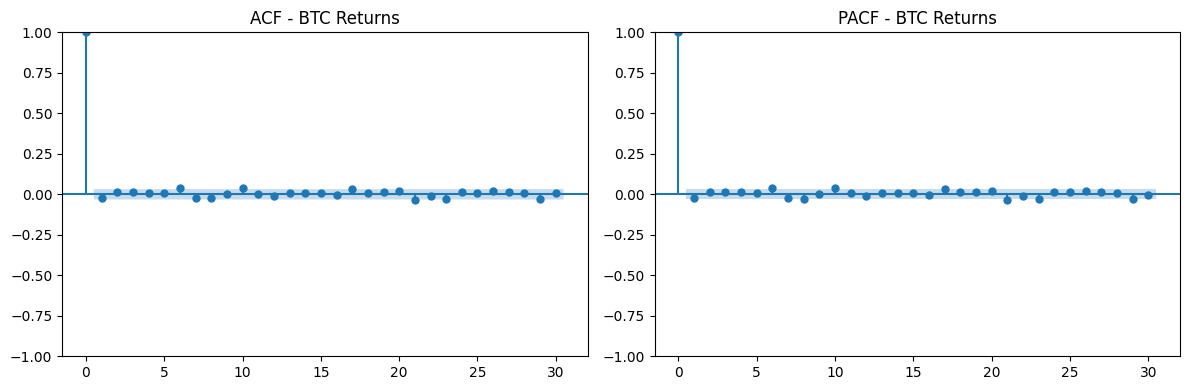

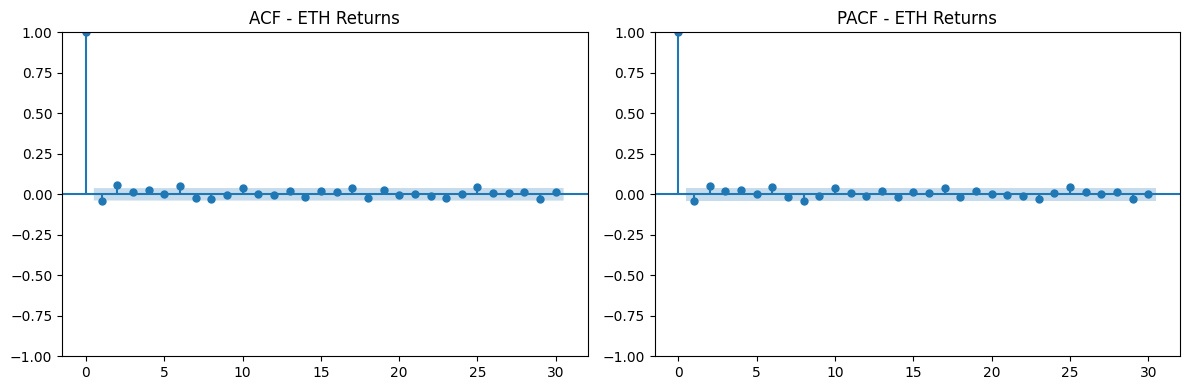

In [14]:
# BTC plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_btc['Return'].dropna(), ax=ax[0], lags=30)
ax[0].set_title('ACF - BTC Returns')
plot_pacf(df_btc['Return'].dropna(), ax=ax[1], lags=30, method='ywm')
ax[1].set_title('PACF - BTC Returns')
plt.tight_layout()
plt.show()

# ETH plots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df_eth['Return'].dropna(), ax=ax[0], lags=30)
ax[0].set_title('ACF - ETH Returns')
plot_pacf(df_eth['Return'].dropna(), ax=ax[1], lags=30, method='ywm')
ax[1].set_title('PACF - ETH Returns')
plt.tight_layout()
plt.show()


For both Bitcoin and Ethereum, the ACF and PACF plots suggest that there is no significant autocorrelation beyond lag 0. This visual evidence supports the hypothesis that the log return series do not exhibit a meaningful time-dependent structure that could be captured by additional AR or MA terms.
The absence of significant autocorrelations beyond lag 0 reinforces the view that the series can be modeled as white noise without any need for further AR or MA components

## Model Selection Using AIC and BIC

To quantitatively support the visual analysis, we perform a grid search over different combinations of the ARIMA parameters p (autoregressive order) and q (moving average order) while keeping d = 0. Each model is evaluated using the AIC and BIC, which balance the quality of the model fit with its complexity. While the AIC tends to favor slightly more complex models, the BIC imposes a stronger penalty on complexity. 


In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Hide convergence warnings

btc_aic_bic_results = []

# Try values from 0 to 4 for p and q
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_btc['Return'].dropna(), order=(p, 0, q))  # d=0 for returns
            result = model.fit()
            btc_aic_bic_results.append({
                'p': p,
                'q': q,
                'AIC': result.aic,
                'BIC': result.bic,
        
            })
        except:
            continue

# Convert to DataFrame and sort
btc_aic_bic_df = pd.DataFrame(btc_aic_bic_results)
print(btc_aic_bic_df)  # Show top 10 models



    p  q           AIC           BIC
0   0  0 -14222.409770 -14209.946486
1   0  1 -14221.894229 -14203.199302
2   0  2 -14220.442388 -14195.515819
3   0  3 -14218.966888 -14187.808677
4   0  4 -14217.417581 -14180.027728
5   1  0 -14221.933090 -14203.238163
6   1  1 -14220.142287 -14195.215719
7   1  2 -14222.034340 -14190.876129
8   1  3 -14216.897270 -14179.507417
9   1  4 -14215.543734 -14171.922238
10  2  0 -14220.406258 -14195.479689
11  2  1 -14218.422078 -14187.263868
12  2  2 -14216.427557 -14179.037704
13  2  3 -14214.557683 -14170.936188
14  2  4 -14213.617603 -14163.764465
15  3  0 -14219.017750 -14187.859539
16  3  1 -14217.028787 -14179.638934
17  3  2 -14215.019762 -14171.398267
18  3  3 -14212.512036 -14162.658898
19  3  4 -14214.734774 -14158.649994
20  4  0 -14217.489815 -14180.099962
21  4  1 -14215.498906 -14171.877411
22  4  2 -14213.476720 -14163.623582
23  4  3 -14213.529196 -14157.444417
24  4  4 -14212.231560 -14149.915138


In [11]:
import warnings
warnings.filterwarnings("ignore")  # Hide convergence warnings

eth_aic_bic_results = []

# Try values from 0 to 4 for p and q
for p in range(5):
    for q in range(5):
        try:
            model = ARIMA(df_eth['Return'].dropna(), order=(p, 0, q))  # d=0 for returns
            result = model.fit()
            eth_aic_bic_results.append({
                'p': p,
                'q': q,
                'AIC': result.aic,
                'BIC': result.bic
            })
        except:
            continue

# Convert to DataFrame and sort
eth_aic_bic_df = pd.DataFrame(eth_aic_bic_results)
print(eth_aic_bic_df)  # Show top 10 models


    p  q          AIC          BIC
0   0  0 -8628.669483 -8616.936039
1   0  1 -8630.719297 -8613.119130
2   0  2 -8636.864592 -8613.397703
3   0  3 -8635.599503 -8606.265892
4   0  4 -8635.452379 -8600.252045
5   1  0 -8631.187234 -8613.587067
6   1  1 -8634.627444 -8611.160555
7   1  2 -8636.595511 -8607.261900
8   1  3 -8633.442430 -8598.242097
9   1  4 -8633.507015 -8592.439959
10  2  0 -8636.828658 -8613.361769
11  2  1 -8637.900202 -8608.566591
12  2  2 -8635.425348 -8600.225015
13  2  3 -8635.546711 -8594.479655
14  2  4 -8632.318632 -8585.384854
15  3  0 -8635.949033 -8606.615422
16  3  1 -8634.007217 -8598.806883
17  3  2 -8634.956937 -8593.889881
18  3  3 -8633.715320 -8586.781541
19  3  4 -8629.818967 -8577.018467
20  4  0 -8635.996085 -8600.795751
21  4  1 -8633.999504 -8592.932448
22  4  2 -8633.162549 -8586.228770
23  4  3 -8631.134017 -8578.333517
24  4  4 -8635.738686 -8577.071463


For Bitcoin, the grid search resulted in the following AIC values: ARIMA(0,0,0) produces an AIC of -14274.50, ARIMA(1,0,0) gives an AIC of -14274.04, and ARIMA(0,0,1) yields an AIC of -14274.01, indicating that the models perform very similarly with a slight edge for ARIMA(0,0,0). 

For Ethereum, the grid search yielded AIC values of -8628.67 for ARIMA(0,0,0), -8631.19 for ARIMA(1,0,0), and -8630.72 for ARIMA(0,0,1), suggesting that ARIMA(1,0,0) offers a marginally better fit. 
Although the differences are small, the BIC values—which impose a stronger penalty on additional parameters—tend to favor simpler models. Overall, these results imply that the log return series for both Bitcoin and Ethereum are broadly consistent with white noise behavior, with little evidence of substantial time-dependent structure in either asset.